# Planet to planet low-thrust transfer

In this tutorial we show the use of the {class}`pykep.trajopt.direct_pl2pl` to find a low-thrust trajectory connecting two moving planets. 

The decision vector in this class compatible with {cite:p}`pagmo` UDPs (User Defined Problems) is:

$$
\mathbf x = [t_0, m_f, V_{sx}^\infty, V^\infty_{sy}, V^\infty_{sz}, V^\infty_{fx}, V^\infty_{fy}, V^\infty_{fz}, u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, ..., T_{tof}]
$$

containing the starting epoch $t_0$ as a MJD2000, the final mass $m_f$ as well as the starting and final $V^{\infty}$, throttles and the time-of-flight $T_{tof}$.

:::{note}
This notebook makes use of the commercial solver SNOPT 7 and to run needs a valid `snopt_7_c` library installed in the system. In case SNOPT7 is not available, you can still run the notebook using, for example `uda = pg.algorithm.nlopt("slsqp")` with minor modifications.

Basic imports:

In [1]:
import pykep as _pk
import numpy as _np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

In [1]:
import numpy as _np
import pykep as _pk

earth = _pk.planet(_pk.udpla.jpl_lp(body="EARTH"))
mars = _pk.planet(_pk.udpla.jpl_lp(body="MARS"))

class direct_pl2pl:
    """Represents the optimal low-thrust transfer between two :class:`~pykep.planet` using a direct method.

    This problem works internally using the :class:`~pykep.leg.sims_flanagan` and manipulates its initial and final states, as well as its transfer time T, final mass mf
    and the controls as to link the two planets with a low-thrust trajectory.

    It can be used to better profile and understand performances of optimizers on this type of direct approach, but has a limited use
    in the design of interplanetary trajectories as per the fixed point limitation.

    The decision vector is::

        z = [t0, mf, Vsx, Vsy, Vsz, Vfx, Vfy, Vfz, throttles, tof]

    where throttles is a vector of throttles structures as [u0x, u0y,u0z, ...]

    """

    def __init__(
        self,
        pls=earth,
        plf=mars,
        ms=1000,
        max_thrust=0.12,
        isp=3000,
        t0_bounds=[4000, 5000],
        tof_bounds=[80, 400],
        mf_bounds=[200.0, 1000.0],
        vinf_dep=1e-3,
        vinf_arr=1e-3,
        nseg=10,
        cut=0.6,
        mass_scaling=1000,
        r_scaling=_pk.AU,
        v_scaling=_pk.EARTH_VELOCITY,
        with_gradient=False,
    ):
        """
        Initializes the direct_pl2pl instance with given parameters.

        Args:
            *rvs* (:class:`list`): Initial position and velocity vectors. Defaults to two vectors scaled by :class:`~pykep.AU` and Earth's velocity.

            *rvf* (:class:`list`): Final position and velocity vectors. Defaults to two vectors scaled by :class:`~pykep.AU` and Earth's velocity.

            *ms* (:class:`float`): Initial spacecraft mass in kg. Defaults to 1000 kg.

            *mu* (:class:`float`): Gravitational parameter, default is for the Sun (:class:`~pykep.MU_SUN`).

            *max_thrust* (:class:`float`): Maximum thrust in Newtons. Defaults to 0.12 N.

            *isp* (:class:`float`): Specific impulse in seconds. Defaults to 3000 s.
            
            *t0_bounds* (:class:`list`): Bounds for departure epoch in MJD2000. Defaults to [4000, 5000] days.

            *tof_bounds* (:class:`list`): Bounds for time of flight in days. Defaults to [0, 400] days.

            *mf_bounds* (:class:`list`): Bounds for final mass in kg. Defaults to [200.0, 1000.0] kg.
            
            *vinf_dep* (:class:`float`): Allowed magnitude for the departure's relative velocity in km/s. Defaults to 1e-3.

            *vinf_arr* (:class:`float`): Allowed magnitude for the arrival's relative velocity in km/s. Defaults to 1e-3.

            *nseg* (:class:`int`): Number of segments for the trajectory. Defaults to 10.

            *cut* (:class:`float`): Cut parameter for the :class:`~pykep.leg.sims_flanagan`. Defaults to 0.6.

            *mass_scaling* (:class:`float`): Scaling factor for mass (used to scale constraints). Defaults to 1000.

            *r_scaling* (:class:`float`): Scaling factor for distance, (used to scale constraints). Defaults AU (:class:`~pykep.AU`).

            *v_scaling* (:class:`float`): Scaling factor for velocity (used to scale constraints). Defaults the Earth's velocity (:class:`~pykep.EARTH_VELOCITY`).

            *with_gradient* (:class:`bool`): Indicates if gradient information should be used. Defaults True.

        """
        # We add as data member one single Sims-Flanagan leg using the problem data
        # and some temporary (and unused, thus irrelelvant) values for the to-be-optimzed parameters throttles, tof and mf.
        throttles = _np.random.uniform(-1, 1, size=(nseg * 3))
        self.leg = _pk.leg.sims_flanagan(
            rvs=rvs,
            ms=ms,
            throttles=throttles,
            rvf=rvf,
            mf=_np.mean(mf_bounds),
            tof=_np.mean(tof_bounds) * _pk.DAY2SEC,
            max_thrust=max_thrust,
            isp=isp,
            mu=mu,
            cut=cut,
        )
        self.tof_bounds = tof_bounds
        self.mf_bounds = mf_bounds
        self.mass_scaling = mass_scaling
        self.r_scaling = r_scaling
        self.v_scaling = v_scaling
        self.with_gradient = with_gradient

    def get_bounds(self):
        lb = [self.mf_bounds[0]] + [-1, -1, -1] * self.leg.nseg + [self.tof_bounds[0]]
        ub = [self.mf_bounds[1]] + [1, 1, 1] * self.leg.nseg + [self.tof_bounds[1]]
        return (lb, ub)

    def _set_leg_from_x(self, x):
        # We set the leg using data in the decision vector
        self.leg.tof = x[-1] * _pk.DAY2SEC
        self.leg.mf = x[0]
        self.leg.throttles = x[1:-1]

    def fitness(self, x):
        # 1 - We set the leg using data in the decision vector
        self._set_leg_from_x(x)
        obj = -x[0] / self.mass_scaling

        # 2 - We compute the constraints violations (mismatch+throttle)
        ceq = self.leg.compute_mismatch_constraints()
        cineq = self.leg.compute_throttle_constraints()
        retval = _np.array([obj] + ceq + cineq)  # here we can sum lists

        # 3 - We scale the values in nd units (numerical solvers are sensitive to well-scaled values)
        retval[1:4] /= self.r_scaling
        retval[4:7] /= self.v_scaling
        retval[7] /= self.mass_scaling

        return retval

    def has_gradient(self):
        return self.with_gradient

    def gradient(self, x):
        self._set_leg_from_x(x)
        _, mcg_xf, mcg_th_tof = self.leg.compute_mc_grad()
        tcg_th = self.leg.compute_tc_grad()

        # 1 - The gradient of the objective function (obj = -mf)
        retval = [-1.0 / self.mass_scaling]
        # 2 - The gradient of the mismatch contraints (mcg). We divide them in pos, vel mass as they have different scaling units
        # pos
        for i in range(3):
            # First w.r.t. mf
            retval.append(mcg_xf[i, -1] / self.r_scaling)
            # Then the [throttles, tof]
            retval.extend(mcg_th_tof[i, :] / self.r_scaling)
            retval[-1] *= _pk.DAY2SEC
        # vel
        for i in range(3, 6):
            # First w.r.t. mf
            retval.append(mcg_xf[i, -1] / self.v_scaling)
            # Then the [throttles, tof]
            retval.extend(mcg_th_tof[i, :] / self.v_scaling)
            retval[-1] *= _pk.DAY2SEC
        # mass
        for i in range(6, 7):
            # First w.r.t. mf
            retval.append(mcg_xf[i, -1] / self.mass_scaling)
            # Then the [throttles, tof]
            retval.extend(mcg_th_tof[i, :] / self.mass_scaling)
            retval[-1] *= _pk.DAY2SEC
        # 3 -  The gradient of the throttle constraints
        for i in range(self.leg.nseg):
            retval.extend(tcg_th[i, 3 * i : 3 * i + 3])

        return retval

    def gradient_sparsity(self):
        dim = 2 + 3 * self.leg.nseg
        # The objective function only depends on the final mass, which is in the chromosome.
        retval = [[0, 0]]
        # The mismatch constraints depend on all variables.
        for i in range(1, 8):
            for j in range(dim):
                retval.append([i, j])
        # The throttle constraints only depend on the specific throttles (3).
        for i in range(self.leg.nseg):
            retval.append([8 + i, 3 * i + 1])
            retval.append([8 + i, 3 * i + 2])
            retval.append([8 + i, 3 * i + 3])
        # We return the sparsity pattern
        return retval

    def get_nec(self):
        return 7

    def get_nic(self):
        return self.leg.nseg

    def pretty(self, x):
        """
        Prints a detailed representation of the Point to point problem.

        Args:
            *x* (:class:`list`): The decision vector containing final mass, thrust direction, and time of flight.
        """
        self._set_leg_from_x(x)
        print(self.leg)

    def plot(
        self,
        x,
        ax=None,
        units=_pk.AU,
        show_midpoints=False,
        show_gridpoints=False,
        show_throttles=False,
        length=0.1,
        arrow_length_ratio=0.05,
        **kwargs
    ):
        """
        Plots the trajectory leg  3D axes.

        Args:
            *x* (:class:`list`): The decision vector containing final mass, thrust direction, and time of flight.

            *ax* (:class:`mpl_toolkits.mplot3d.axes3d.Axes3D`, optional): The 3D axis to plot on. Defaults to None.

            *units* (:class:`float`, optional): The unit scale for the plot. Defaults to _pk.AU.

            *show_midpoints* (:class:`bool`, optional): Whether to show midpoints on the trajectory. Defaults to False.

            *show_gridpoints* (:class:`bool`, optional): Whether to show grid points on the trajectory. Defaults to False.

            *show_throttles* (:class:`bool`, optional): Whether to show throttle vectors. Defaults to False.

            *length* (:class:`float`, optional): Length of the throttle vectors. Defaults to 0.1.

            *arrow_length_ratio* (:class:`float`, optional): Arrow length ratio for the throttle vectors. Defaults to 0.05.

            *\*\*kwargs*: Additional keyword arguments for the plot.

        Returns:
            :class:`mpl_toolkits.mplot3d.axes3d.Axes3D`: The 3D axis with the plotted trajectory.
        """
        self._set_leg_from_x(x)
        sf = self.leg
        # Making the axis
        if ax is None:
            ax = _pk.plot.make_3Daxis(figsize=(7, 7))

        rs, _ = sf.rvs
        rf, _ = sf.rvf
        ax.scatter(rs[0] / _pk.AU, rs[1] / units, rs[2] / units, c="k", s=20)
        ax.scatter(rf[0] / _pk.AU, rf[1] / units, rf[2] / units, c="k", s=20)

        # Plotting the trajctory leg
        ax = _pk.plot.add_sf_leg(
            ax,
            sf,
            units=units,
            show_throttles=show_throttles,
            length=length,
            show_gridpoints=show_gridpoints,
            show_midpoints=show_midpoints,
            arrow_length_ratio=arrow_length_ratio,
            **kwargs
        )

        return ax


AttributeError: 'pykep.core.planet' object has no attribute 'mu_central_body'

In [20]:
# Problem data
mu = pk.MU_SUN
max_thrust = 0.12
isp = 3000

# Initial state
ms = 1500.0
rs = np.array([1.2, 0.0, -0.01]) * pk.AU
vs = np.array([0.01, 1, -0.01]) * pk.EARTH_VELOCITY

# Final state
mf = 1300.0
rf = np.array([1, 0.0, -0.0]) * pk.AU
vf = np.array([0.01, 1.1, -0.0]) * pk.EARTH_VELOCITY

# Throttles and tof
nseg = 4
throttles = np.random.uniform(-1, 1, size=(nseg * 3))
tof = 2 * np.pi * np.sqrt(pk.AU**3 / pk.MU_SUN) / 4

udp_nog = pk.trajopt.direct_point2point(
    rvs=[rs, vs],
    rvf=[rf, vf],
    mu=pk.MU_SUN,
    max_thrust=0.22,
    isp=3000,
    tof_bounds=[200, 500],
    mf_bounds=[200.0, 1000.0],
    nseg=nseg,
    cut=0.6,
    with_gradient=False,
)

udp_g = pk.trajopt.direct_point2point(
    rvs=[rs, vs],
    rvf=[rf, vf],
    mu=pk.MU_SUN,
    max_thrust=0.22,
    isp=3000,
    tof_bounds=[200, 500],
    mf_bounds=[200.0, 1000.0],
    nseg=nseg,
    cut=0.6,
    with_gradient=True,
)

In [21]:
snopt72 = "/usr/local/lib/libsnopt7_c.so"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 2000)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-12)

# uda = pg.nlopt("slsqp")
algo = pg.algorithm(uda)

In [22]:
prob_nog = pg.problem(udp_nog)
prob_nog.c_tol = 1e-6
prob_g = pg.problem(udp_g)
prob_g.c_tol = 1e-6
pop_g = pg.population(prob_g, 1)
pop_g = algo.evolve(pop_g)
print(prob_g.feasibility_f(pop_g.champion_f))

True


Mismatch on pos: [ 1.57696078e-12  1.61709535e-12 -1.75156764e-13]
Mismatch on mass: 4.126786734559573e-08


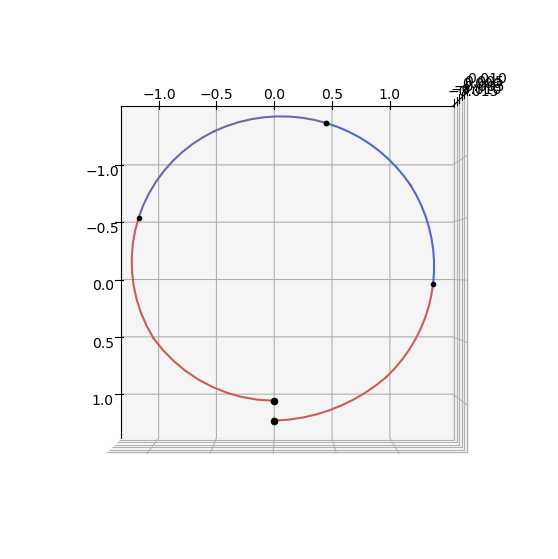

In [23]:
ax = udp_nog.plot(pop_g.get_x()[0], show_gridpoints=True)
ax.view_init(90, 0)

In [27]:
from tqdm import tqdm

cpu_nog = []
cpu_g = []

fail_g = 0
fail_nog = 0

for i in tqdm(range(2000)):
    pop_nog = pg.population(prob_nog, 1)

    pop_g = pg.population(prob_g)
    pop_g.push_back(pop_nog.get_x()[0])

    start = time.time()
    pop_g = algo.evolve(pop_g)
    end = time.time()
    cpu_g.append(end - start)
    if not prob_g.feasibility_f(pop_g.champion_f):
        fail_g += 1

    start = time.time()
    pop_nog = algo.evolve(pop_nog)
    end = time.time()
    cpu_nog.append(end - start)
    if not prob_nog.feasibility_f(pop_nog.champion_f):
        fail_nog += 1

print(f"Gradient: {np.median(cpu_g):.4e}s")
print(f"No Gradient: {np.median(cpu_nog):.4e}s")

print(f"\nGradient (n.fails): {fail_g}")
print(f"No Gradient (n.fails): {fail_nog}")

100%|██████████| 2000/2000 [02:18<00:00, 14.45it/s]

Gradient: 1.8443e-02s
No Gradient: 3.0552e-02s
Gradient: 192
No Gradient: 188


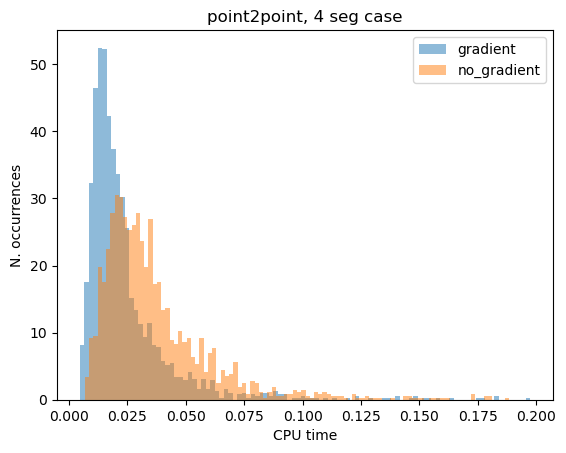

In [30]:
cpu_g = np.array(cpu_g)
cpu_nog = np.array(cpu_nog)
plt.hist(cpu_g[cpu_g < 0.2], bins=100, label="gradient", density=True, alpha=0.5)
plt.hist(cpu_nog[cpu_nog < 0.2], bins=100, label="no_gradient", density=True, alpha=0.5)
# plt.xlim([0,0.15])
plt.legend()
plt.title("point2point, 4 seg case")
plt.xlabel("CPU time")
plt.ylabel("N. occurrences")